In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
df = pd.read_csv('adult.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
print(df.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


In [ ]:
categorical_cols = df.select_dtypes(include='object').columns

print("Categorical Columns Analysis:\n")
for col in categorical_cols:
    print(f"Column: {col}")
    print(f"Unique values: {df[col].unique()}")
    print(f"Value counts:\n{df[col].value_counts()}\n")

Categorical Columns Analysis:

Column: workclass
Unique values: ['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']
Value counts:
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

Column: education
Unique values: ['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']
Value counts:
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           3

In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

print("Numerical Columns Descriptive Statistics:")
print(df[numerical_cols].describe())

Numerical Columns Descriptive Statistics:
                age        fnlwgt  education.num  capital.gain  capital.loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours.per.week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


In [ ]:
#pre-processing data anomalies
# 1. Drop redundant column
df = df.drop(columns=['education'])

# 2. Group Rare Categories (Example for Country)
# Get counts of each country
country_counts = df['native.country'].value_counts()
# Create list of countries with less than 50 samples
rare_countries = country_counts[country_counts < 50].index
# Replace them with 'Other'
df.loc[df['native.country'].isin(rare_countries), 'native.country'] = 'Other'

# (Repeat similar logic for 'workclass' if desired)

# 3. Log transform skewed continuous features
# We add +1 to avoid log(0) error
df['capital.gain'] = np.log1p(df['capital.gain'])
df['capital.loss'] = np.log1p(df['capital.loss'])

In [ ]:
# --- 1. CONFIGURATION ---
# Define which columns are which (based on your df.info)
categorical_cols = ['workclass', 'marital.status', 'occupation', 'relationship',
                    'race', 'sex', 'native.country']
# Note: 'education.num' is technically categorical (ordinal), but we can treat it as numeric
# or embed it. Let's treat it as numeric for simplicity, or add to categorical if you want embeddings.
numerical_cols = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
target_col = 'income'

# --- 2. CATEGORICAL ENCODING (The "stoi" step) ---
# We store the "vocab size" (number of unique classes) for each column.
# We will need this later to define: nn.Embedding(vocab_size, dim)
vocab_sizes = {}

for col in categorical_cols:
    # Convert to category type
    df[col] = df[col].astype('category')
    # Save the number of classes (add 1 for potential unknown handling if needed later, usually safe here)
    vocab_sizes[col] = len(df[col].cat.categories)
    # Replace strings with integers (0, 1, 2...)
    df[col] = df[col].cat.codes

# Encode Target (Income) -> 0 and 1
df[target_col] = df[target_col].apply(lambda x: 1 if x == '>50K' else 0)

print("Categorical Encoding Complete.")
print(f"Vocabulary Sizes (for Embeddings): {vocab_sizes}")

Categorical Encoding Complete.
Vocabulary Sizes (for Embeddings): {'workclass': 9, 'marital.status': 7, 'occupation': 15, 'relationship': 6, 'race': 5, 'sex': 2, 'native.country': 23}


Using device: cpu
Splitting Data...
Split Sizes -> Train: (26048, 13), Val: (3256, 13), Test: (3257, 13)
Scaling Numerical Data...
Class Imbalance Weight: 3.15

Running LR Finder...


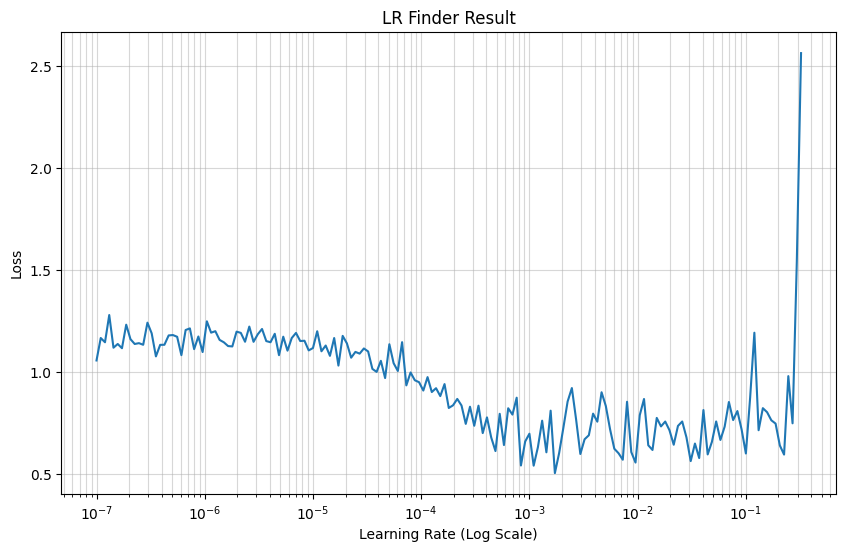


SETUP COMPLETE. Check the Plot, then run 'train_modern_model(LR)'


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- CONFIGURATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. SPLIT DATA (Resetting Split)
# ---------------------------------------------------------
print("Splitting Data...")
# Re-running the split to ensure clean state
X = df.drop(target_col, axis=1)
y = df[target_col]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Split Sizes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# 2. NUMERICAL SCALING
# ---------------------------------------------------------
print("Scaling Numerical Data...")
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols]   = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols]  = scaler.transform(X_test[numerical_cols])

# 3. PREPARE DATASETS & LOADERS
# ---------------------------------------------------------
class CensusDataset(Dataset):
    def __init__(self, X, y, cat_cols, num_cols):
        self.X_cat = X[cat_cols].values.astype('int64')
        self.X_cont = X[num_cols].values.astype('float32')
        self.y = y.values.astype('float32').reshape(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_cont[idx], self.y[idx]

batch_size = 128 # Increased batch size for stability with BatchNorm

train_dataset = CensusDataset(X_train, y_train, categorical_cols, numerical_cols)
val_dataset   = CensusDataset(X_val, y_val, categorical_cols, numerical_cols)
test_dataset  = CensusDataset(X_test, y_test, categorical_cols, numerical_cols)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. CALCULATE CLASS WEIGHT (For Imbalance)
# ---------------------------------------------------------
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
pos_weight_value = num_neg / num_pos
pos_weight_tensor = torch.tensor([pos_weight_value]).to(device)

print(f"Class Imbalance Weight: {pos_weight_value:.2f}")

# 5. DEFINE MODERN ARCHITECTURE (ResNet + GELU)
# ---------------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout_rate):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim)
        )
        self.activation = nn.GELU()

    def forward(self, x):
        return self.activation(self.block(x) + x) # Skip connection

class ModernCensusModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont, hidden_dim=256, dropout_rate=0.3):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(num, dim) for num, dim in embedding_sizes
        ])
        self.n_emb_out = sum(e.embedding_dim for e in self.embeddings)

        # Initial projection
        self.first_layer = nn.Sequential(
            nn.Linear(self.n_emb_out + n_cont, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )

        # Deep Residual Network (3 Blocks)
        self.res_blocks = nn.Sequential(
            ResidualBlock(hidden_dim, dropout_rate),
            ResidualBlock(hidden_dim, dropout_rate),
            ResidualBlock(hidden_dim, dropout_rate)
        )

        # Output
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x_cat, x_cont):
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x_emb = torch.cat(embeddings, dim=1)
        x = torch.cat([x_emb, x_cont], dim=1)

        x = self.first_layer(x)
        x = self.res_blocks(x)
        return self.output_layer(x)

# Setup Embeddings
emb_dims = [(size, min(50, (size + 1) // 2)) for size in vocab_sizes.values()]

# 6. LEARNING RATE FINDER
# ---------------------------------------------------------
def lr_finder(model, train_loader, optimizer, criterion, device):
    print("\nRunning LR Finder...")
    model.train()
    lrs = []
    losses = []

    lr_start = 1e-7
    lr_end = 10
    num_steps = len(train_loader)
    gamma = (lr_end / lr_start) ** (1 / num_steps)

    optimizer.param_groups[0]['lr'] = lr_start
    current_lr = lr_start

    for i, (x_cat, x_cont, y) in enumerate(train_loader):
        x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(x_cat, x_cont)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        lrs.append(current_lr)
        losses.append(loss.item())

        current_lr *= gamma
        optimizer.param_groups[0]['lr'] = current_lr

        if i > 10 and loss.item() > min(losses) * 4: # Stop if diverging
            break

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate (Log Scale)')
    plt.ylabel('Loss')
    plt.title('LR Finder Result')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

# Run Finder
temp_model = ModernCensusModel(emb_dims, len(numerical_cols)).to(device)
temp_opt = torch.optim.AdamW(temp_model.parameters(), lr=1e-7)
temp_crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

lr_finder(temp_model, train_loader, temp_opt, temp_crit, device)

# 7. FINAL TRAINING FUNCTION
# ---------------------------------------------------------
def train_modern_model(learning_rate, epochs=15):
    print(f"\nStarting Final Training with LR: {learning_rate}")

    # Re-init fresh model
    model = ModernCensusModel(emb_dims, len(numerical_cols)).to(device)

    # Loss with Class Weights
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01) # Higher weight decay for regularization
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x_cat, x_cont, y in train_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(x_cat, x_cont)
            loss = criterion(y_pred, y)
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            running_loss += loss.item()

        # Validate
        model.eval()
        val_acc = 0.0
        batches = 0
        with torch.no_grad():
            for x_cat, x_cont, y in val_loader:
                x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
                output = model(x_cat, x_cont)

                # Check accuracy with threshold 0.5 (Sigmoid applied)
                preds = (torch.sigmoid(output) > 0.5).float()
                val_acc += (preds == y).sum().item() / y.size(0)
                batches += 1

        avg_val_acc = val_acc / batches
        avg_loss = running_loss / len(train_loader)

        # Step Scheduler
        scheduler.step(avg_val_acc)
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Val Acc: {avg_val_acc*100:.2f}% | LR: {current_lr:.1e}")

    return model

print("\nSETUP COMPLETE. Check the Plot, then run 'train_modern_model(LR)'")

In [ ]:
def train_modern_model(learning_rate, epochs=15):
    print(f"\nStarting Final Training with LR: {learning_rate}")

    # Re-init fresh model
    model = ModernCensusModel(emb_dims, len(numerical_cols)).to(device)

    # Loss with Class Weights
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

    # FIXED: Removed 'verbose=True'
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x_cat, x_cont, y in train_loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(x_cat, x_cont)
            loss = criterion(y_pred, y)
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            running_loss += loss.item()

        # Validate
        model.eval()
        val_acc = 0.0
        batches = 0
        with torch.no_grad():
            for x_cat, x_cont, y in val_loader:
                x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
                output = model(x_cat, x_cont)

                # Check accuracy with threshold 0.5
                preds = (torch.sigmoid(output) > 0.5).float()
                val_acc += (preds == y).sum().item() / y.size(0)
                batches += 1

        avg_val_acc = val_acc / batches
        avg_loss = running_loss / len(train_loader)

        # Step Scheduler
        scheduler.step(avg_val_acc)
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Val Acc: {avg_val_acc*100:.2f}% | LR: {current_lr:.1e}")

    return model

# Run with your chosen LR (Recommended: 3e-4)
final_model = train_modern_model(learning_rate=3e-4, epochs=20)


Starting Final Training with LR: 0.0003
Epoch 1/20 | Loss: 0.6693 | Val Acc: 77.20% | LR: 3.0e-04
Epoch 2/20 | Loss: 0.6229 | Val Acc: 78.83% | LR: 3.0e-04
Epoch 3/20 | Loss: 0.6041 | Val Acc: 77.70% | LR: 3.0e-04
Epoch 4/20 | Loss: 0.5938 | Val Acc: 78.44% | LR: 3.0e-04
Epoch 5/20 | Loss: 0.5888 | Val Acc: 79.41% | LR: 3.0e-04
Epoch 6/20 | Loss: 0.5821 | Val Acc: 79.70% | LR: 3.0e-04
Epoch 7/20 | Loss: 0.5799 | Val Acc: 78.31% | LR: 3.0e-04
Epoch 8/20 | Loss: 0.5741 | Val Acc: 79.46% | LR: 3.0e-04
Epoch 9/20 | Loss: 0.5706 | Val Acc: 78.31% | LR: 3.0e-05
Epoch 10/20 | Loss: 0.5594 | Val Acc: 79.16% | LR: 3.0e-05
Epoch 11/20 | Loss: 0.5582 | Val Acc: 79.16% | LR: 3.0e-05
Epoch 12/20 | Loss: 0.5549 | Val Acc: 79.22% | LR: 3.0e-06
Epoch 13/20 | Loss: 0.5498 | Val Acc: 78.70% | LR: 3.0e-06
Epoch 14/20 | Loss: 0.5533 | Val Acc: 78.97% | LR: 3.0e-06
Epoch 15/20 | Loss: 0.5530 | Val Acc: 79.40% | LR: 3.0e-07
Epoch 16/20 | Loss: 0.5515 | Val Acc: 78.88% | LR: 3.0e-07
Epoch 17/20 | Loss: 0.55

              precision    recall  f1-score   support

       <=50K       0.95      0.79      0.86      2473
        >50K       0.56      0.86      0.68       784

    accuracy                           0.81      3257
   macro avg       0.76      0.82      0.77      3257
weighted avg       0.85      0.81      0.82      3257



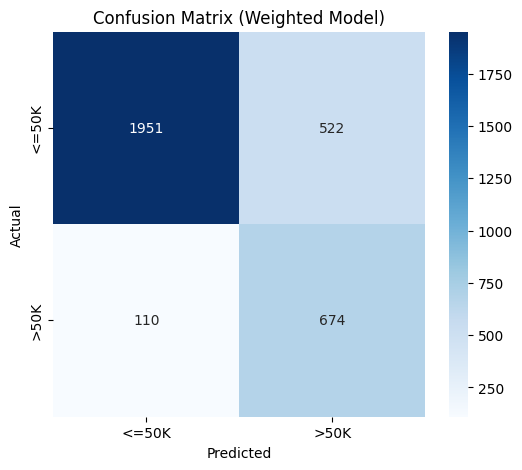

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_performance(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_cat, x_cont, y in loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            output = model(x_cat, x_cont)

            # Since we trained with weighted loss, the logits are shifted.
            # We still use sigmoid > 0.5 as a baseline, but this is tunable.
            preds = (torch.sigmoid(output) > 0.5).float()

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Print Report
    print(classification_report(y_true, y_pred, target_names=['<=50K', '>50K']))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Weighted Model)')
    plt.show()

evaluate_performance(final_model, test_loader, device)

/tmp/ipython-input-1518282386.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[ms_col].replace(


Before SMOTE: Counter({np.int64(0): 17291, np.int64(1): 5501})
After SMOTE: Counter({np.int64(0): 17291, np.int64(1): 17291})

XGBoost Accuracy: 83.04%

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.94      0.83      0.88      7429
        >50K       0.61      0.83      0.70      2340

    accuracy                           0.83      9769
   macro avg       0.77      0.83      0.79      9769
weighted avg       0.86      0.83      0.84      9769



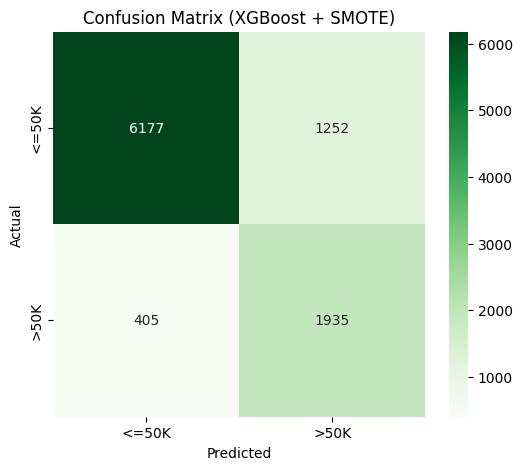

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

# 1. Load Data
df = pd.read_csv('adult.csv')

# 2. Preprocessing
# Fix: Using np.nan instead of np.NaN
df = df.replace("?", np.nan)

# Fill missing with mode
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Discretization (Marital Status)
# Check for correct column name (dot vs hyphen)
ms_col = 'marital.status' if 'marital.status' in df.columns else 'marital-status'
df[ms_col].replace(
    ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent',
     'Never-married', 'Separated', 'Widowed'],
    ['divorced', 'married', 'married', 'married',
     'not married', 'not married', 'not married'], inplace=True
)

# Encode Labels
labelEncoder = preprocessing.LabelEncoder()
# Check for column names (dot vs hyphen) and adapt
cols_to_encode = ['workclass', 'race', 'education', ms_col, 'occupation',
                  'relationship', 'sex', 'native.country', 'income']

# Handle varying names in raw csv
actual_cols = df.columns.tolist()
for col in cols_to_encode:
    # Try finding the column even if names vary slightly
    if col in actual_cols:
        df[col] = labelEncoder.fit_transform(df[col])
    # Fallback for common mismatches
    elif col == 'native.country' and 'country' in actual_cols:
        df['country'] = labelEncoder.fit_transform(df['country'])
    elif col == 'income' and 'salary' in actual_cols:
        df['salary'] = labelEncoder.fit_transform(df['salary'])

# Feature Selection
# Drop fnlwgt and education-num/education.num
drop_cols = [c for c in ['fnlwgt', 'education.num', 'education-num'] if c in df.columns]
df = df.drop(drop_cols, axis=1)

# X/Y Split
# Assuming Income is the last column
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# 3. SMOTE (Oversampling)
print("Before SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_train_SMOTE))

# 4. Train XGBoost (GradientBoostingClassifier)
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_SMOTE, y_train_SMOTE)
preds = gb_clf.predict(X_test)

# 5. Results
acc = accuracy_score(y_test, preds)
print(f"\nXGBoost Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, preds, target_names=['<=50K', '>50K']))

# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost + SMOTE)')
plt.show()

To achieve 85% Precision (Safety):
Set Threshold to: 0.8952
New Recall will be: 38.78% (Loans you can still safely issue)


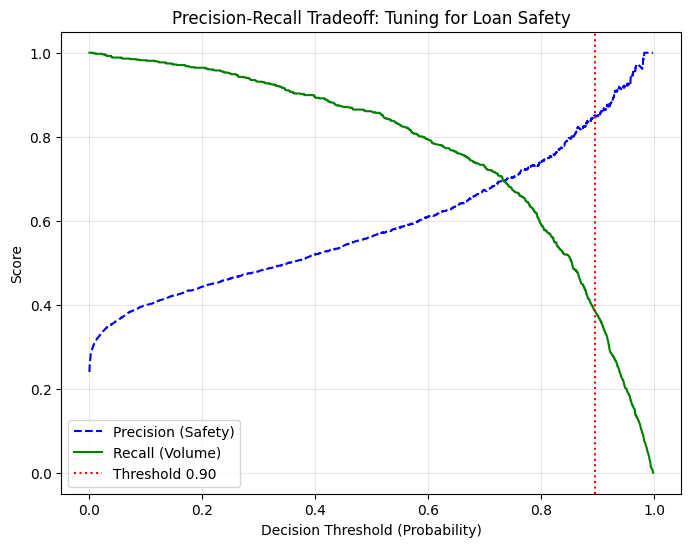

In [ ]:
from sklearn.metrics import precision_recall_curve

def find_safe_threshold(model, loader, target_precision=0.80):
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for x_cat, x_cont, y in loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            logits = model(x_cat, x_cont)
            probs = torch.sigmoid(logits) # Convert logit to 0-1 probability

            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Calculate P-R Curve
    precisions, recalls, thresholds = precision_recall_curve(all_targets, all_probs)

    # Find the threshold where Precision first crosses the target (e.g., 0.80)
    # We search backwards because precision usually goes up as threshold goes up
    safe_threshold = 0.5 # Default
    current_recall = 0.0

    for p, r, t in zip(precisions, recalls, thresholds):
        if p >= target_precision:
            safe_threshold = t
            current_recall = r
            break

    print(f"To achieve {target_precision*100:.0f}% Precision (Safety):")
    print(f"Set Threshold to: {safe_threshold:.4f}")
    print(f"New Recall will be: {current_recall*100:.2f}% (Loans you can still safely issue)")

    # Plotting the Trade-off
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision (Safety)")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall (Volume)")
    plt.axvline(x=safe_threshold, color='r', linestyle=':', label=f'Threshold {safe_threshold:.2f}')
    plt.xlabel("Decision Threshold (Probability)")
    plt.ylabel("Score")
    plt.title("Precision-Recall Tradeoff: Tuning for Loan Safety")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return safe_threshold

# Run it
new_threshold = find_safe_threshold(final_model, test_loader, target_precision=0.85)

In [ ]:
# Get probabilities from XGBoost (Class 1)
y_prob_xgb = gb_clf.predict_proba(X_test)[:, 1]

# Calculate P-R Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# Find recall at 85% precision
idx = next(i for i, p in enumerate(precisions) if p >= 0.85)
print(f"XGBoost Recall at 85% Precision: {recalls[idx]*100:.2f}%")

XGBoost Recall at 85% Precision: 49.02%


In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from collections import Counter

# 1. Load & Preprocess (Same robust logic as before)
df = pd.read_csv('adult.csv')

# Handling missing values
df = df.replace("?", np.nan)
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Discretization
ms_col = 'marital.status' if 'marital.status' in df.columns else 'marital-status'
df[ms_col].replace(
    ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent',
     'Never-married', 'Separated', 'Widowed'],
    ['divorced', 'married', 'married', 'married',
     'not married', 'not married', 'not married'], inplace=True
)

# Label Encoding
labelEncoder = preprocessing.LabelEncoder()
cols_to_encode = ['workclass', 'race', 'education', ms_col, 'occupation',
                  'relationship', 'sex', 'native.country', 'income']

actual_cols = df.columns.tolist()
for col in cols_to_encode:
    if col in actual_cols:
        df[col] = labelEncoder.fit_transform(df[col])
    elif col == 'native.country' and 'country' in actual_cols:
        df['country'] = labelEncoder.fit_transform(df['country'])
    elif col == 'income' and 'salary' in actual_cols:
        df['salary'] = labelEncoder.fit_transform(df['salary'])

# Drop redundant cols
drop_cols = [c for c in ['fnlwgt', 'education.num', 'education-num'] if c in df.columns]
df = df.drop(drop_cols, axis=1)

# Split
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# 2. CALCULATE SCALE_POS_WEIGHT (Replacing SMOTE)
# Formula: sum(negative instances) / sum(positive instances)
counter = Counter(y_train)
estimate = counter[0] / counter[1]
print(f"Imbalance Ratio (scale_pos_weight): {estimate:.2f}")

# 3. HYPERPARAMETER TUNING (Random Search)
# We define a grid of parameters to test
param_dist = {
    'n_estimators': [100, 200, 300, 500],        # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     # Step size
    'max_depth': [3, 4, 5, 6, 8, 10],            # Depth of trees
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],    # % of features to use per tree
    'subsample': [0.6, 0.7, 0.8, 1.0],           # % of rows to use per tree (prevent overfitting)
    'scale_pos_weight': [1, estimate],           # Test both: standard and weighted
    'gamma': [0, 0.1, 0.2]                       # Minimum loss reduction required
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Search across 50 combinations (3-fold cross-validation)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy', # Or 'recall' if you want to prioritize safety
    cv=3,
    verbose=1,
    n_jobs=-1, # Use all CPU cores
    random_state=42
)

print("\nStarting Hyperparameter Tuning (this may take a minute)...")
random_search.fit(X_train, y_train)

# 4. EVALUATE BEST MODEL
best_model = random_search.best_estimator_
print(f"\nBest Parameters Found: {random_search.best_params_}")

preds = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, preds)
print(f"\nTuned XGBoost Accuracy: {acc*100:.2f}%")
print(classification_report(y_test, preds, target_names=['<=50K', '>50K']))

# Check the "Safety Threshold" (Recall at 85% Precision)
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
idx = next((i for i, p in enumerate(precisions) if p >= 0.85), -1)
if idx != -1:
    print(f"Recall at 85% Precision: {recalls[idx]*100:.2f}%")
else:
    print("Could not reach 85% Precision with this model.")

# 5. EXPORT (Seamless Replacement)
pickle.dump(best_model, open('model_tuned.pkl', 'wb'))
print("Saved tuned model to 'model_tuned.pkl'")

/tmp/ipython-input-1058817020.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[ms_col].replace(


Imbalance Ratio (scale_pos_weight): 3.14

Starting Hyperparameter Tuning (this may take a minute)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:52:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters Found: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}

Tuned XGBoost Accuracy: 87.53%
              precision    recall  f1-score   support

       <=50K       0.89      0.95      0.92      7429
        >50K       0.80      0.64      0.71      2340

    accuracy                           0.88      9769
   macro avg       0.85      0.79      0.82      9769
weighted avg       0.87      0.88      0.87      9769

Recall at 85% Precision: 55.34%
Saved tuned model to 'model_tuned.pkl'
